# REGRESSION MODEL USING ZILLOW DATA

- By Nisha Bista
- Source My SQL server

In [1]:
#python libraries
import pandas as pd
import numpy as np
import os

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# Import homemade files
from env import get_connection
import wrangle as w
import explore as e

# Import scikit-learn for split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Import for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler,QuantileTransformer

# Import for feature selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from scipy.stats import pearsonr, spearmanr

# Import scikit-learn modeling 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score


# PROJECT DESCRIPTION
This project predicts factors contributing to 2017 property tax assessed values for three California counties ( Orange County, Ventura, Los Angeles). The data collected from this project can help with future planning on ways to decrease property tax and improve loyalty to the Zillow brand.

# PROJECT GOALS
- The aim of this project is to create a machine learning model to accurately predict the value of single-family homes using their features.
- Find out the key factors that affect the tax values of single-family homes sold in 2017.
- Share the results with the head data scientist and other important people at Zillow.

# INITIAL QUESTIONS
- Is there a correlation between the number of bathrooms and the property's tax value?
- Does the property's square footage influence its value?
- Is the number of bedrooms linked to the property's tax value?
- How significantly does the size of the lot affect the property's value?

# AQUISITION AND PREPARATION
- Data was acquired from the database Zillow data.

- The dataset initially consisted of 7 columns and 52,442 rows before any cleaning procedures were applied.

- Each row in the dataset represents a single-family home property.

- The data was prepared by performing various steps. Firstly, the columns were renamed to enhance readability. Null values and duplicate rows were dropped. Data types were modified to facilitate exploration and modeling.

- The county information, labeled as "fips," was renamed appropriately.

- To address skewed data, outliers were removed. For instance, properties with more than 6 bedrooms or bathrooms and prices exceeding 2M were considered outliers.

- Resulting in 50,268 rows or %95 of original data used to maintain data integrity

- The data was split into training, validation, and testing sets using a 50%, 30%, 20% split, respectively using Random State of 123.



In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
#Data is acquired & prepared so no missed values and outliers removed
df = w.final_wrangle()
df.head()

,bedrooms,bathrooms,sqft,tax_value,lot_size,year_built,county
0,4,3,3100,1023282,4506,1998,Orange Cty
1,2,1,1465,464000,12647,1967,Ventura
2,3,2,1243,564778,8432,1962,Orange Cty
3,4,3,2376,145143,13038,1970,Los Angeles
4,4,3,2962,773303,63000,1950,Los Angeles


In [4]:
# Datasets split 
train, validate, test = w.split_zillow(df)

Train shape: (30160, 7)
Validate shape: (10054, 7)
Test shape: (10054, 7)


# EXPLORATORY ANALYSIS


# Is there a correlation between the number of bathrooms and the property's tax value?


The box plot illustrates the distribution of the number of bathrooms in single-family homes (SFH) across different counties, with respect to the corresponding tax values for each county Plot.

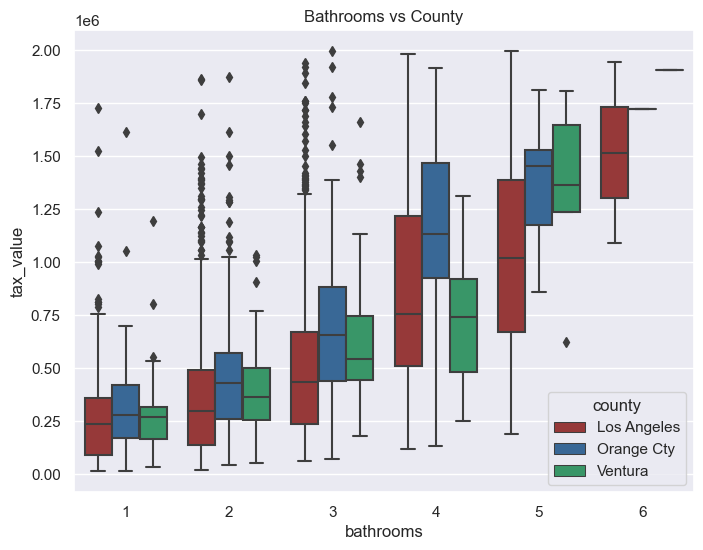

In [5]:
# Visual correlation between bathrooms and County tax values
e.bath_box(train)

In [6]:
# Pearson R used for statistical testing to verify visual assessment
e.bath_stat(train, validate, test)

train_r: 0.47732870798577987
train_p: 0.0
validate_r: 0.4802109419754402
validate_p: 0.0
The p-value is less than the alpha: True
Outcome: We reject the null


Bathroom Takeaways
- H0 = Number of Bathrooms has no relationship with of property tax value.
- Ha = Number of Bathrooms has a relationship with property tax value Outcome:


   We reject the null hypothesis


# How significantly does the size of the lot affect the property's value?

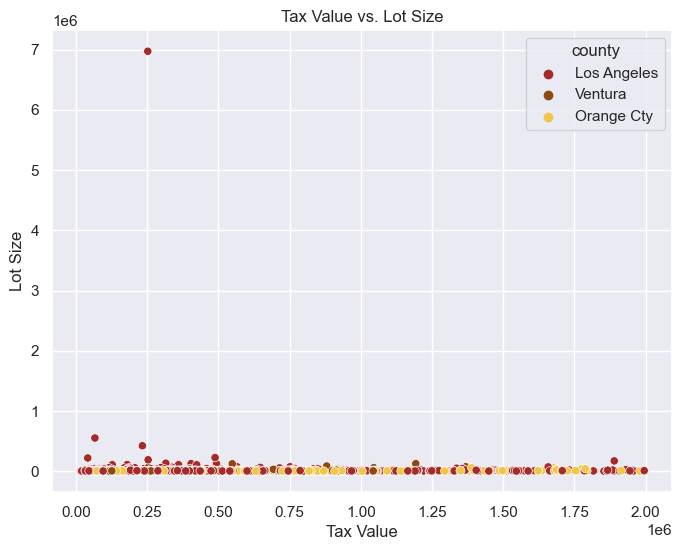

In [21]:
#Very extremely low if any signficant relations between tax Value and Lot Size
plt.figure(figsize = (8,6))
e.lot_scat(train)

The scatter plot shows how tax values relate to the lot size of single-family homes across various counties.

In [8]:
#Spearman R used for statistical testing extremely low correlation positive between lot size and tax value. * inconsistent findings of both rejecting and accepting the null depending on sample. 
e.lot_stat(train, validate, test)

train_r: 0.12404093945836081
train_p: 1.0588600550643867e-103
validate_r: 0.11829717000653499
validate_p: 1.156127453547721e-32
test_r: 0.11786331578651658
test_p: 1.956077621107671e-32
The p-value is less than the alpha: True
Outcome: We reject the null


Lot Size Takeaways

- H0= Lot Size has no significant correlation with property tax value. Outcome: We reject the null
- Ha= Lot Size is correlated to property tax value

# 2.Is the number of bedrooms linked to the property's tax value?

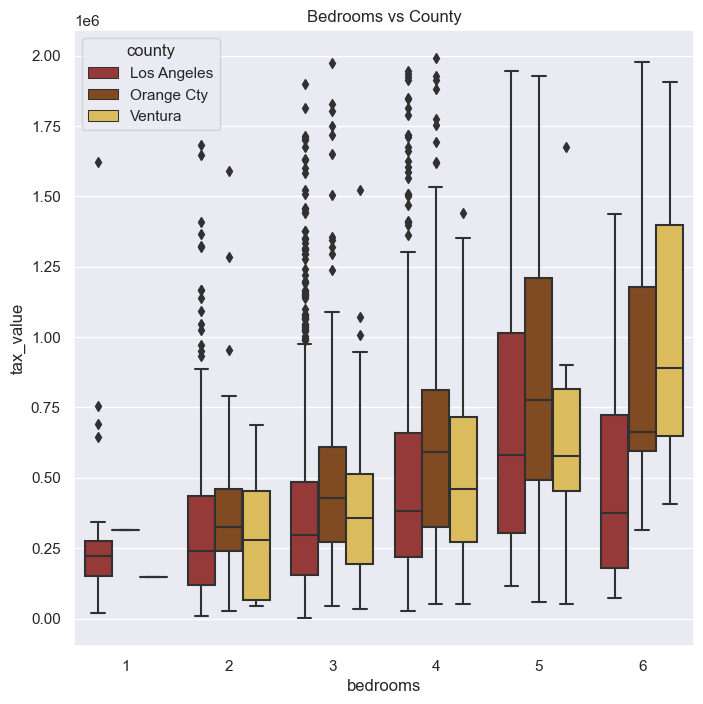

In [24]:
# Visual relationship between bedrooms and tax values
plt.figure(figsize=(8, 8))

e.bed_in_box(train)


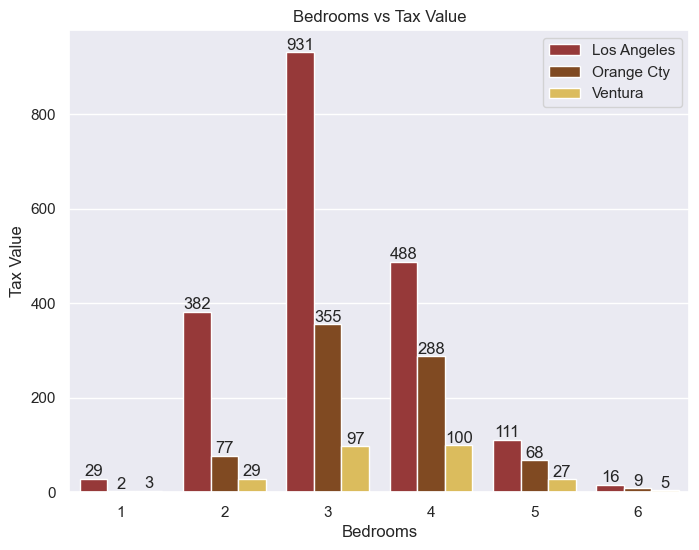

In [22]:
#Normal distribution of bedrooms compared to county
plt.figure(figsize=(8, 6))

e.bed_in_bar(train)

In [11]:
#Used Pearson R for stat test to confirm findings
e.bedrooms_stat(train, validate, test)

train_r: 0.2686572782045818
train_p: 0.0
validate_r: 0.2783837210826507
validate_p: 2.4130750275960395e-178
The p-value is less than the alpha: True
Outcome: We reject the null


The correlation coefficients (r-values) for both the training and validation datasets indicate a positive relationship, with extremely small p-values. This suggests a significant correlation and supports the use of the Pearson R correlation test, indicating a somewhat normal distribution of the data. 
- H0 = Number of Bedrooms has no relationship with property tax value. Outcome: We reject the null
- Ha = Number of Bedrooms has a relationship with on property tax value

# EXPLORATION SUMMARRY


- All features have some level of connection with property tax value in the three counties, though the strength varies.
- More large, high-value homes with 6+ bedrooms are found in Los Angeles County.
- Bathrooms affect tax value more than bedrooms do. Ventura has fewer one-bedroom homes, while Orange County has a balanced mix.
- For bedrooms,  bathrooms, and lot size, our tests show a significant link with property tax value.

# MODELING


Will be using RMSE as an evaluation metric, making Baseline the mean 'value'.

In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test = w.x_y_split(train, validate, test)
X_train.head(1)

,bedrooms,bathrooms,sqft,lot_size,year_built
27062,4,2,2070,6942,1968


In [13]:
y_train.mean(), y_train.median()


(443467.66372679046, 363359.0)

In [14]:
#Baseline
y_train, y_validate, metric_df = e.baseline(y_train, y_validate)

In [15]:
metric_df = pd.DataFrame()

In [16]:
metric_df = pd.DataFrame(metric_df)


In [17]:
print(type(metric_df))


<class 'pandas.core.frame.DataFrame'>


In [18]:
import pandas as pd
# Run the models and compare their metrics to identify the best performing one.
y_train, y_validate, metric_df = e.ols_lasso_tweedie(X_train, X_validate, y_train, y_validate, metric_df)

#Compare metrics
# metric_df.head()

AttributeError: 'DataFrame' object has no attribute 'concat'

# LASSO + LARS MODEL SELECTED

In [19]:
e.lasso_test_model(X_train, y_train, X_test, y_test)


RMSE for Lasso+Lars:
    _____________________________________________      
    Test Performance: 285222.37
    Test Explained Variance: 0.343
    Baseline: 443467.66


- the RMSE is 285,222.37. Lower RMSE values indicate better model performance, as they represent smaller prediction errors.
-  Lasso+Lars model explains about 34.3% of the variance in the test data. In other words, it suggests that the model is capturing some of the patterns in the data but not all.
-  The baseline model has a higher value (443,467.66) than your Lasso+Lars model's RMSE, suggesting that  model is performing better than the baseline. 

# CONCLUSION
This project aimed to develop a robust machine learning regression model for accurately forecasting the assessed values of single-family properties. The analysis encompassed three distinct counties and identified the following key findings:

- The number of bedrooms had a lesser impact on tax values compared to bathrooms.
- Los Angeles County showed a higher average of single-family homes with 6+ bedrooms, indicating higher tax values and larger lot sizes.
- The rejection of null hypotheses for bedrooms,  bathrooms, and lot size highlighted their significant associations with property tax values. The top-performing models, OLS and Lasso+Lars, achieved superior results, surpassing the baseline, and justifying the selection of Lasso+Lars (alpha = 0.03) for further analysis.

# RECOMMENDATION
- Utilize the Interquartile Range (IQR) approach during the data cleaning process to mitigate overfitting and account for the inherent skewness in the data.
- Avoid using the "fireplace" and "basement" variables in the analysis due to a high number of null values, despite their notable correlations with tax value prediction.